#MIE1517 PROJECT FINAL REPORT

#Deep Learning-Based Brain Tumor Classification Using MRI Images

###Team 2
Amine Mazouzi, Basak Kaya, Calise Moldawa, Haisu Wang

Table of Content
* Problem statement
* Introduction and objective
* Dataset preparation, splitting, and distribution analysis
* Model implementation and training
* Baseline model
* Validation and hyperparameter tuning
* Performance evaluation
* Performance comparison
* Discussion
* Reproducibilty
* Demo
* Presentation
* Resources

The link to the Google Colab: https://colab.research.google.com/drive/1x2jZGgooGeg4JwpIBX8UwZD8X9u4SH6T#scrollTo=sZH9NgA0CYor

# Problem Statement

Accurate diagnosis of brain tumors depends on the expert interpretation of MRI scans by radiologists. However, becoming a radiologist is an extremely long process, typically requiring 13–15 years of education and training (4 years of undergraduate study, 4 years of medical school, 1 year of internship, and 4–6 years of residency and fellowship). Despite this extensive preparation, radiologists today face unprecedented workloads: global imaging volume has increased by over 300% in the past two decades, and in many hospitals a single radiologist may review up to 20,000 imaging studies per year. This rising demand increases stress, prolongs diagnosis times, and heightens the risk of fatigue-related errors. These challenges highlight the need for automated tools that can support clinical decision-making and improve diagnostic efficiency.

This project addresses that need by developing a deep learning model capable of classifying brain tumor MRI images into clinically meaningful categories. By automating part of the diagnostic workflow, such systems have the potential to reduce radiologist workload, speed up detection, and provide more consistent and accessible medical image interpretation—especially in regions with limited access to highly trained specialists.

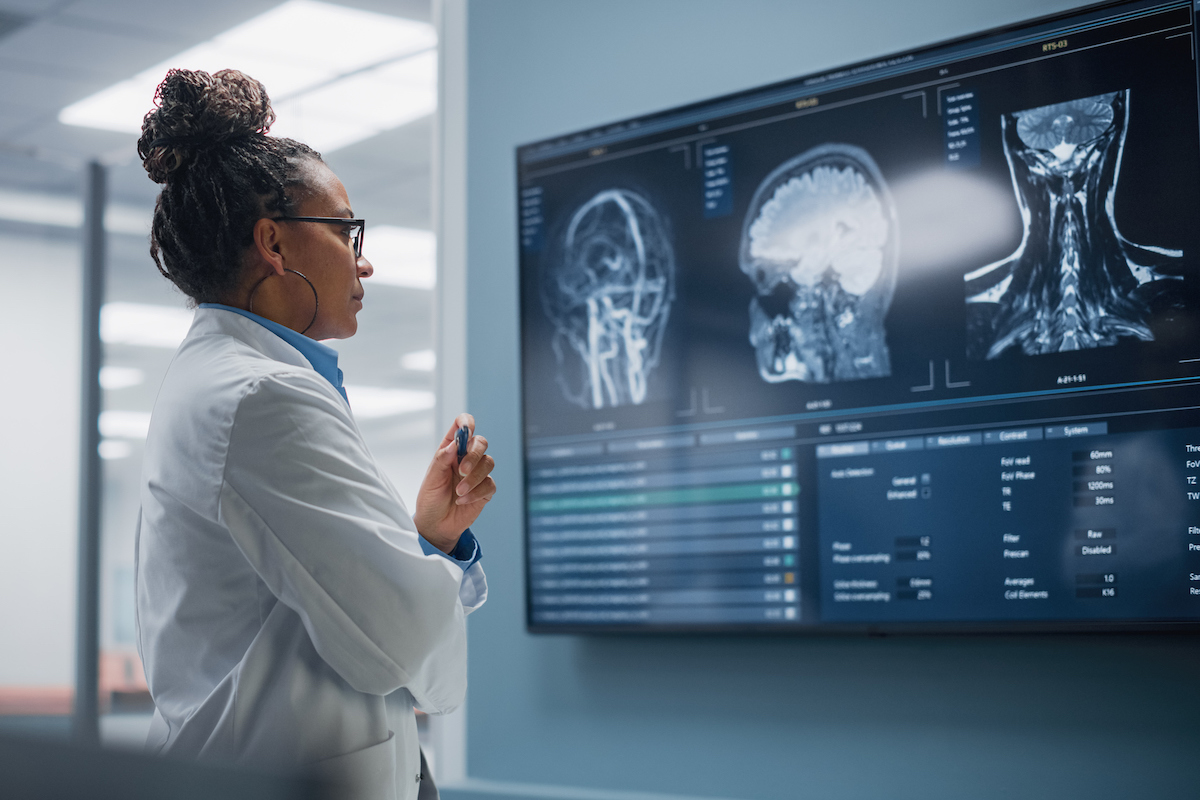

#Introduction and Objective

This project applies deep learning techniques to classify brain tumor MRI images using the **Kaggle Brain Tumor MRI Dataset** and the **Roboflow Dataset**. The primary objective is to develop and evaluate convolutional neural network (CNN) architectures capable of accurately distinguishing between various tumor types and healthy tissue. The workflow includes:
1. **Dataset preparation, splitting, and distribution analysis**
2. **Model implementation and training**
3. **Baseline model**
4. **Validation and hyperparameter tuning**
5. **Performance evaluation**
6. **Performance comparison**
7. **Discussion**

Ultimately, this project aims to advance automated medical image analysis, enabling faster and more reliable tumor detection.




The following diagram shows how an MRI image is processed by our ResNet-50 model. The image is
first resized to 224 x 224, then it is passed into the fine-tuned ResNet-50 model. Finally, the model outputs one of the four classes: no_tumor, pituitary, meningioma, and glioma. This completes the end-to-end pipeline from input images to final multiclass prediction.

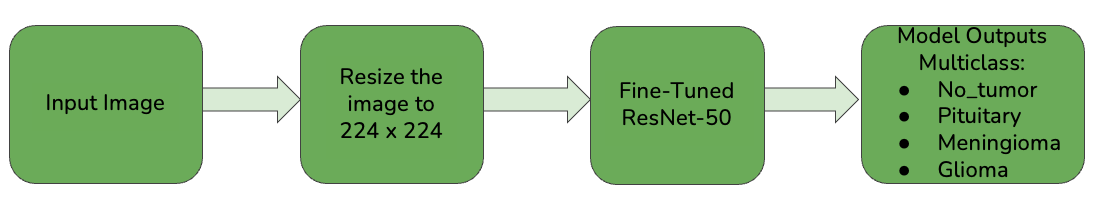

###Datasets:

Kaggle dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


Roboflow dataset: https://universe.roboflow.com/ali-rostami/labeled-mri-brain-tumor-dataset

# 1. Dataset Preparation, Splitting, and Distribution Analysis
We used two different datasets: **Kaggle** and **Roboflow**. The Kaggle dataset was utilized for training and validation, while the Roboflow dataset was reserved exclusively for testing.

In [ ]:
# Import split-folders to split Kaggle data into training and validation
!pip install split-folders
import os
import numpy as np
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import splitfolders

### Kaggle Dataset (training and validation)

Num training images:  5712
Num validation images:  1311

Training images per class:
glioma: 1321
meningioma: 1339
notumor: 1595
pituitary: 1457

Validation images per class:
glioma: 300
meningioma: 306
notumor: 405
pituitary: 300


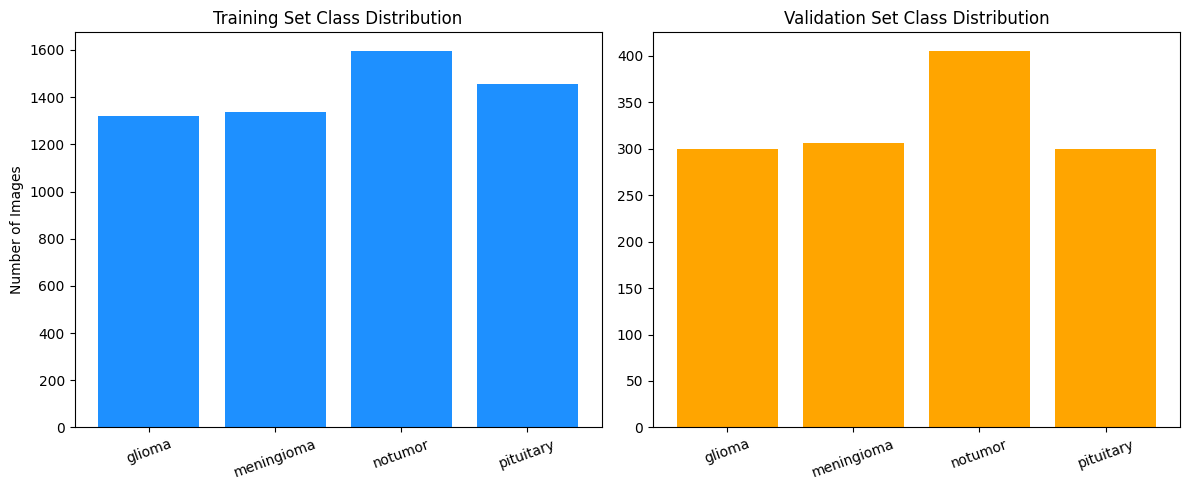

In [ ]:
# Import Kaggle data (already downloaded as a zip file)
_ = !unzip '/content/Kaggle_MRI_Dataset.zip' -d '/content/Kaggle_MRI_Dataset/'

# define training and test data directories
train_dir = '/content/Kaggle_MRI_Dataset/Training'
val_dir = '/content/Kaggle_MRI_Dataset/Testing'

# classes are folders in each directory with these names
classes = ['pituitary', 'notumor', 'meningioma', 'glioma']

# load and transform data using ImageFolder
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)

# print out overall stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))

# Print number of images per class
from collections import Counter
import matplotlib.pyplot as plt

train_counts = Counter(train_data.targets)
val_counts = Counter(val_data.targets)

print("\nTraining images per class:")
for idx, count in train_counts.items():
    print(f"{train_data.classes[idx]}: {count}")

print("\nValidation images per class:")
for idx, count in val_counts.items():
    print(f"{val_data.classes[idx]}: {count}")

# Histogram (Bar Chart) of Class Distribution
plt.figure(figsize=(12,5))

# Training histogram
plt.subplot(1, 2, 1)
plt.bar(train_data.classes, [train_counts[i] for i in range(len(train_data.classes))], color='dodgerblue')
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)

# Validation histogram
plt.subplot(1, 2, 2)
plt.bar(val_data.classes, [val_counts[i] for i in range(len(val_data.classes))], color='orange')
plt.title("Validation Set Class Distribution")
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

# dataloaders
batch_size  = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=False)


The Kaggle dataset contains **7,023 MRI images**, which we split **80/20** between training and validation—resulting in **5,712 training images** and **1,311 validation images**. The dataset is organized into **four distinct classes**, each represented by a separate folder: **pituitary**, **notumor**, **meningioma**, and **glioma**. Each folder contains MRI scans corresponding to its respective category, with pituitary, meningioma, and glioma representing diagnosed tumor cases, and notumor representing healthy individuals without tumor presence.

An analysis of the class distribution shows that all four categories are relatively **well balanced**. In the training set, glioma and meningioma have approximately 1,300–1,350 images each, pituitary contains around 1,450 images, and notumor is the largest class with roughly 1,600 images. The validation set follows a similar pattern, with each class containing around 300 images, except for notumor, which has just over 400 samples. This balanced distribution helps the model learn each tumor type effectively and reduces the risk of bias toward any single class.

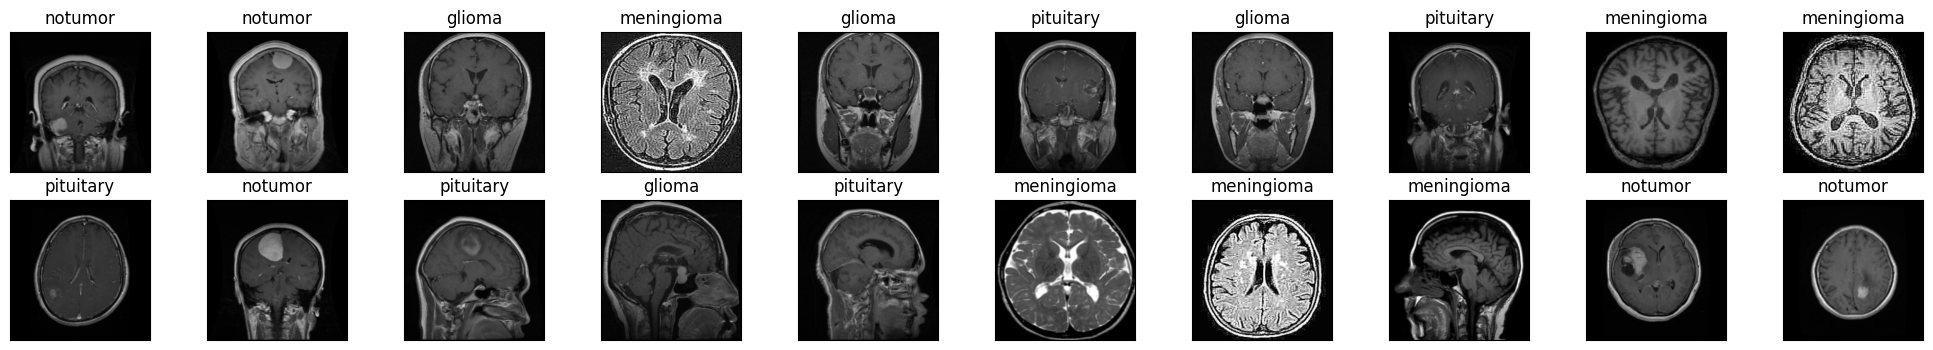

In [ ]:
# Visualize some sample data
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


This figure shows a selection of sample MRI images from all four classes in the Kaggle dataset: notumor, pituitary, glioma, and meningioma. The examples illustrate the natural variability in scan orientations, contrast levels, and tumor appearances across patients.

### Roboflow Dataset (testing)

Num test images:  1695

Test images per class:
glioma: 564
meningioma: 358
notumor: 335
pituitary: 438


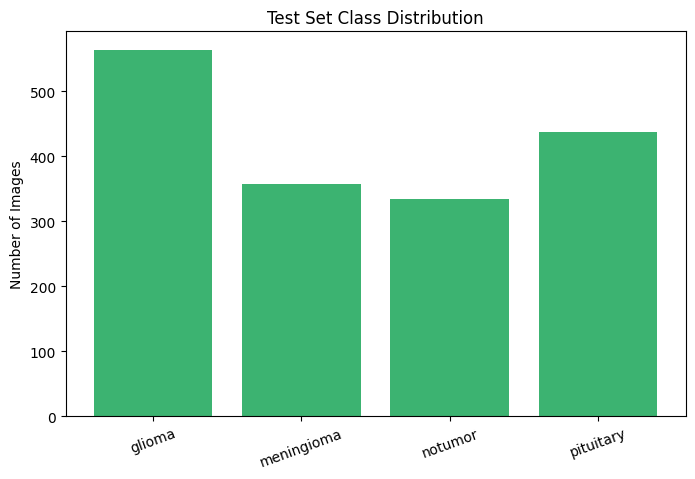

In [ ]:
# Import Roboflow dataset for Testing (Use the whole dataset for testing)
_ = !unzip '/content/Roboflow_MRI_Dataset.zip' -d '/content/Roboflow_MRI_Dataset/'

test_dir = '/content/Roboflow_MRI_Dataset/Roboflow_MRI_Dataset'

# Resize all images to 224 x 224
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_data = datasets.ImageFolder(test_dir, transform=data_transform)
print('Num test images: ', len(test_data))

# Print class counts
from collections import Counter
import matplotlib.pyplot as plt

test_counts = Counter(test_data.targets)

print("\nTest images per class:")
for idx, count in test_counts.items():
    print(f"{test_data.classes[idx]}: {count}")

# Histogram of class distribution
plt.figure(figsize=(8, 5))
plt.bar(test_data.classes, [test_counts[i] for i in range(len(test_data.classes))],
        color='mediumseagreen')
plt.title("Test Set Class Distribution")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.show()

# DataLoader
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=False)


The Roboflow test dataset contains 1,695 MRI images distributed across the same four classes as the training set. As shown in the histogram, the largest class is glioma, with more than 550 images, followed by pituitary, which contains around 440 samples. The meningioma and notumor classes are somewhat smaller, with roughly 360 and 340 images respectively. Although the distribution is not perfectly uniform, each class is still well represented, making the dataset suitable for evaluating how well the model generalizes across all brain tumor categories.

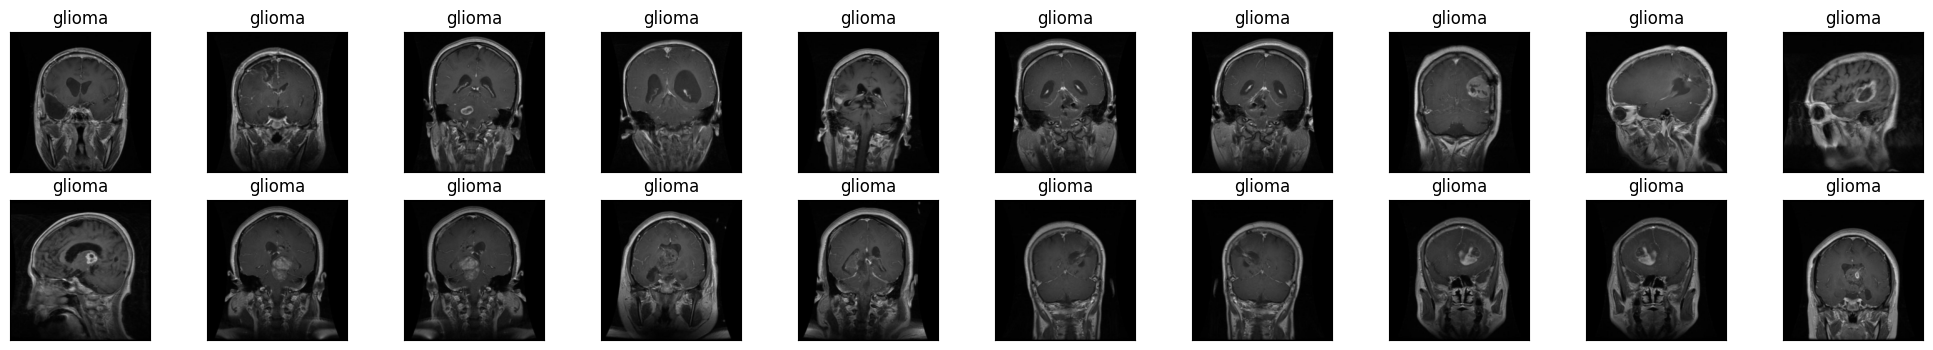

In [ ]:
# Visualize sample data
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.numpy()  # convert images to numpy

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(test_data.classes[labels[idx]])

This figure shows sample MRI images from Roboflow dataset.

# 2. Model Implementation and Training: ResNet-50 Based CNN Model

This code implements a convolutional neural network (CNN) model for classifying brain tumor MRI images using a transfer learning approach with the pre-trained **ResNet-50** model, which has 50 layers with learnable weights. The ResNet-50 model architecture is shown below. The final fully connected layer is modified to output four classes corresponding to the dataset categories: glioma, meningioma, pituitary, and notumor. The model is trained using **stochastic gradient descent (SGD)** optimization and **cross-entropy loss** to minimize classification errors. During training, the code monitors both **loss** and **accuracy** for the training and validation datasets over multiple epochs, and visualizes these metrics to evaluate model performance and generalization.

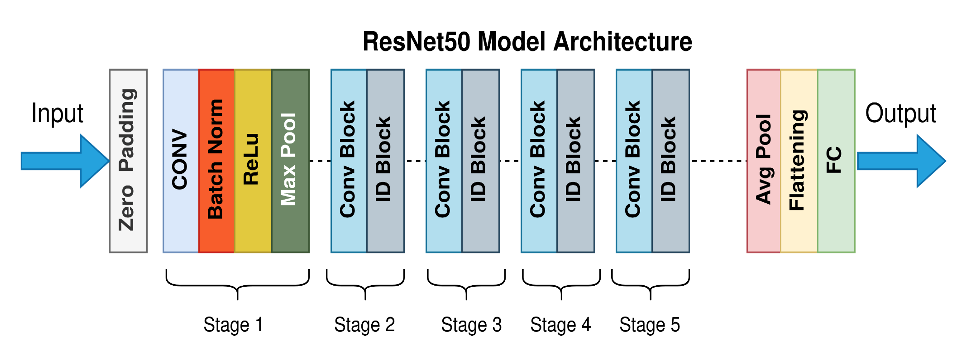

Image Source: https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758/

In [ ]:
# ResNet-50 model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the last layer of the model
num_classes = 4
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)  # for Resnet model

# Define device here
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 83.4MB/s]


In [ ]:
# Training ResNet-50

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("mps" if torch.backends.mps.is_available()
                          else "cuda" if torch.cuda.is_available()
                          else "cpu")

    # Move model to device
    model = model.to(device)

    # Lists to store metrics for plotting later
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # main training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.float() / len(train_loader.dataset)

        # validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0


        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.float() / len(val_loader.dataset)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc.item())
        val_accuracies.append(val_acc.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, '
              f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

    # Plot training curves after all epochs
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch [1/10], train loss: 0.6771, train acc: 0.7775, val loss: 0.5088, val acc: 0.8116
Epoch [2/10], train loss: 0.4242, train acc: 0.8650, val loss: 0.4480, val acc: 0.8276
Epoch [3/10], train loss: 0.3772, train acc: 0.8739, val loss: 0.4353, val acc: 0.8261
Epoch [4/10], train loss: 0.3512, train acc: 0.8811, val loss: 0.4035, val acc: 0.8459
Epoch [5/10], train loss: 0.3298, train acc: 0.8873, val loss: 0.3641, val acc: 0.8619
Epoch [6/10], train loss: 0.3121, train acc: 0.8969, val loss: 0.3694, val acc: 0.8543
Epoch [7/10], train loss: 0.3041, train acc: 0.8955, val loss: 0.3527, val acc: 0.8642
Epoch [8/10], train loss: 0.2890, train acc: 0.9020, val loss: 0.3452, val acc: 0.8688
Epoch [9/10], train loss: 0.2860, train acc: 0.9004, val loss: 0.3421, val acc: 0.8635
Epoch [10/10], train loss: 0.2829, train acc: 0.9023, val loss: 0.3570, val acc: 0.8642


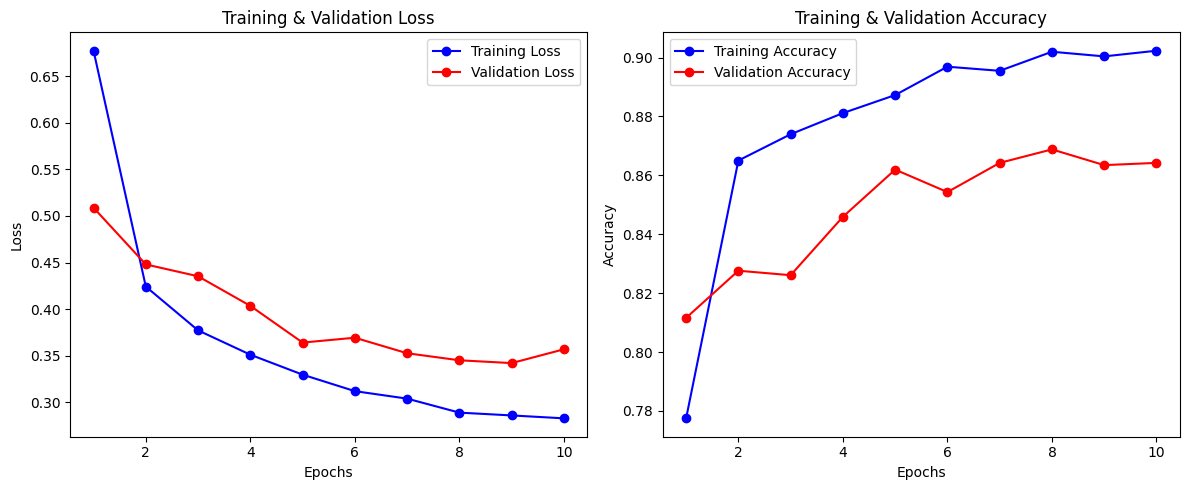

In [ ]:
# Training

# Move model to device and start training
model = model.to(device)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


The graphs above illustrate the model’s performance during training over ten epochs. In the **Training and Validation Loss** graph, both loss values decrease consistently, indicating that the model is effectively learning and minimizing errors. The validation loss follows a similar downward trend, suggesting good generalization without overfitting. In the **Training and Validation Accuracy** graph, both training and validation accuracies increase steadily, reaching around 90% and 88%, respectively. The close alignment between the two curves demonstrates that the model performs reliably on unseen data and achieves a strong balance between learning and generalization.

# 3. Baseline Model

A baseline CNN model was implemented to establish a simple benchmark for comparison against the more advanced ResNet-50 architecture. The baseline CNN model architecture was shown in the figure below. This baseline network consists of three convolutional layers with **batch normalization** and **max-pooling**, followed by two fully connected layers for classification into the four tumor categories. It represents a lightweight, non-pre-trained architecture designed to capture fundamental spatial patterns in the MRI images. The model was trained for 10 epochs using the same training and validation splits, with Adam optimization and cross-entropy loss. Evaluating this baseline model allows for a meaningful comparison of performance, highlighting the improvements gained through transfer learning with ResNet-50 and providing a clearer understanding of model complexity versus accuracy.

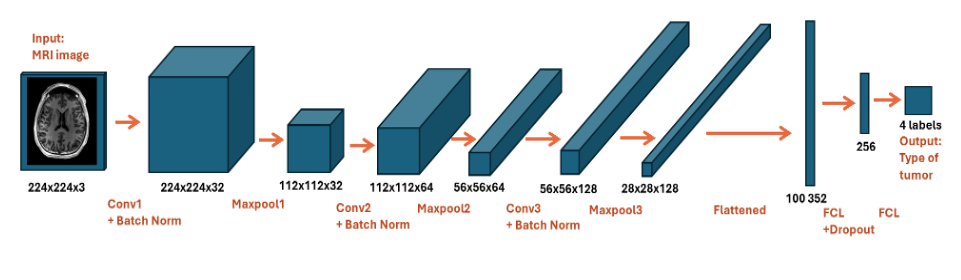

In [ ]:
# Baseline model

import torch
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BaselineCNN, self).__init__()

        # Feature extractor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Classifier for 224x224 input to final size = 128 x 28 x 28
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Epoch [1/10], train loss: 2.0525, train acc: 0.5933, val loss: 0.7067, val acc: 0.7574
Epoch [2/10], train loss: 0.7199, train acc: 0.6977, val loss: 0.5556, val acc: 0.7605
Epoch [3/10], train loss: 0.6392, train acc: 0.7230, val loss: 0.5269, val acc: 0.7712
Epoch [4/10], train loss: 0.5991, train acc: 0.7390, val loss: 0.5612, val acc: 0.7429
Epoch [5/10], train loss: 0.5989, train acc: 0.7419, val loss: 0.7368, val acc: 0.7605
Epoch [6/10], train loss: 0.5385, train acc: 0.7558, val loss: 0.4147, val acc: 0.8185
Epoch [7/10], train loss: 0.5560, train acc: 0.7493, val loss: 0.3960, val acc: 0.8185
Epoch [8/10], train loss: 0.5605, train acc: 0.7595, val loss: 0.4800, val acc: 0.8047
Epoch [9/10], train loss: 0.5143, train acc: 0.7703, val loss: 0.4040, val acc: 0.8291
Epoch [10/10], train loss: 0.4671, train acc: 0.8093, val loss: 0.3850, val acc: 0.8040


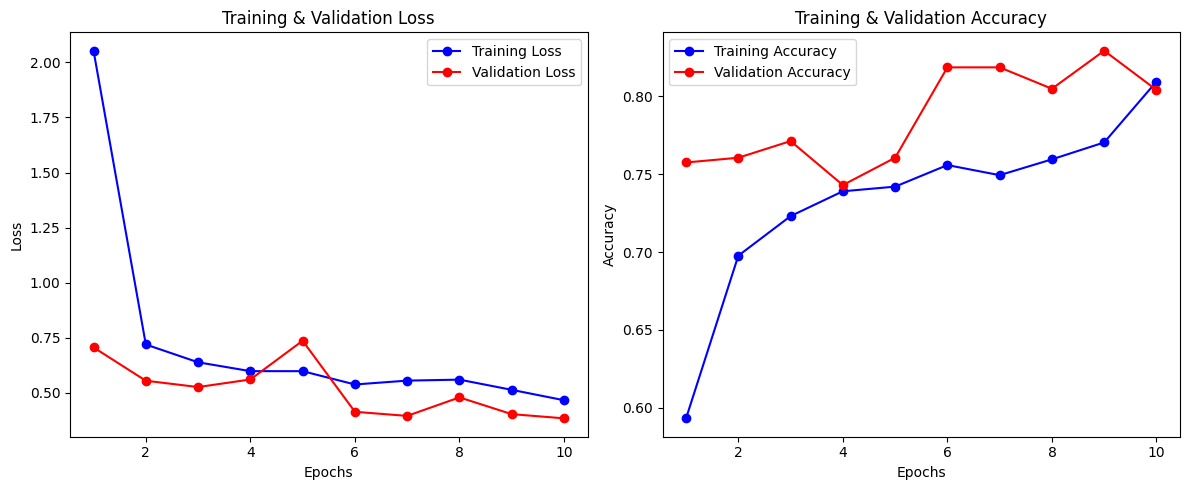

In [ ]:
# Training the baseline CNN model

model2 = BaselineCNN(num_classes=4)

optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

model2 = model2.to(device)
train(model2, train_loader, val_loader, criterion, optimizer, num_epochs=10)

The training curves for the **baseline CNN model** illustrate how the simpler architecture learns over the 10-epoch training process.

In the Training & Validation Loss graph, the training loss decreases sharply after the first epoch and continues to decline steadily, while the validation loss follows a similar downward trend with only minor fluctuations. This indicates that the baseline model is able to learn meaningful features from the MRI images and maintain reasonable generalization.

The Training & Validation Accuracy graph shows consistent improvement in both training and validation accuracy, with the validation accuracy rising to the 80–84% range by the final epochs. Overall, the curves demonstrate that the baseline CNN achieves solid performance despite its limited depth, providing an effective benchmark for comparison with the more advanced ResNet-50 model.

# 4. Validation and Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning

import itertools
import torch
import torch.nn as nn
import torchvision.models as models


# training for one run (no plots)
def train_one_run(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.float() / len(train_loader.dataset)

        # validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.float() / len(val_loader.dataset)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, "
              f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

    return best_val_acc.item()


# Hyperparameter tuning
criterion = nn.CrossEntropyLoss()

# search space
learning_rates = [1e-2, 5e-3, 1e-3]
momenta        = [0.9, 0.95]
weight_decays  = [0.0, 1e-4]

num_epochs = 10

best_config = None
best_val_acc = 0.0

for lr, mom, wd in itertools.product(learning_rates, momenta, weight_decays):

    print(f"\n=== New run: lr={lr}, momentum={mom}, weight_decay={wd} ===")

    # fresh ResNet-50 each time
    model_tuned = models.resnet50(pretrained=True)
    num_classes = 4
    model_tuned.fc = nn.Linear(model_tuned.fc.in_features, num_classes)

    optimizer = torch.optim.SGD(
        model_tuned.fc.parameters(),
        lr=lr,
        momentum=mom,
        weight_decay=wd
    )

    val_acc = train_one_run(
        model_tuned,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=num_epochs,
        device=device
    )

    print(f"Validation accuracy for this config: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = {"lr": lr, "momentum": mom, "weight_decay": wd}

print("\n========================")
print("Best hyperparameters:")
print(best_config)
print(f"Best validation accuracy: {best_val_acc:.4f}")


To further improve the performance of the **ResNet-50 model**, a hyperparameter tuning procedure was conducted using a **grid search** approach. In this step, multiple combinations of key hyperparameters—**learning rate**, **momentum**, and **weight decay**—were systematically evaluated to determine which configuration yielded the **highest validation accuracy**. For each combination, a fresh ResNet-50 model was initialized, trained for several epochs, and assessed on the validation set to ensure fair comparison. This process allowed the model’s optimization behavior and generalization performance to be explored in a structured manner. The tuning experiment identified the optimal hyperparameters as a **learning rate of 0.01**, **momentum of 0.9**, and **weight decay of 0.0001**, achieving **the best validation accuracy of 92.52%**. These results demonstrate that careful hyperparameter selection significantly enhances the model’s effectiveness and stability.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], train loss: 0.4989, train acc: 0.8150, val loss: 0.3909, val acc: 0.8635
Epoch [2/10], train loss: 0.3765, train acc: 0.8690, val loss: 0.5236, val acc: 0.8146
Epoch [3/10], train loss: 0.3678, train acc: 0.8706, val loss: 0.3495, val acc: 0.8764
Epoch [4/10], train loss: 0.2757, train acc: 0.9007, val loss: 0.3530, val acc: 0.8711
Epoch [5/10], train loss: 0.2529, train acc: 0.9076, val loss: 0.3156, val acc: 0.8932
Epoch [6/10], train loss: 0.3542, train acc: 0.8810, val loss: 0.2780, val acc: 0.8978
Epoch [7/10], train loss: 0.2686, train acc: 0.9053, val loss: 0.2531, val acc: 0.9085
Epoch [8/10], train loss: 0.2457, train acc: 0.9112, val loss: 0.2542, val acc: 0.9100
Epoch [9/10], train loss: 0.2306, train acc: 0.9147, val loss: 0.2819, val acc: 0.8871
Epoch [10/10], train loss: 0.2488, train acc: 0.9076, val loss: 0.2463, val acc: 0.9115


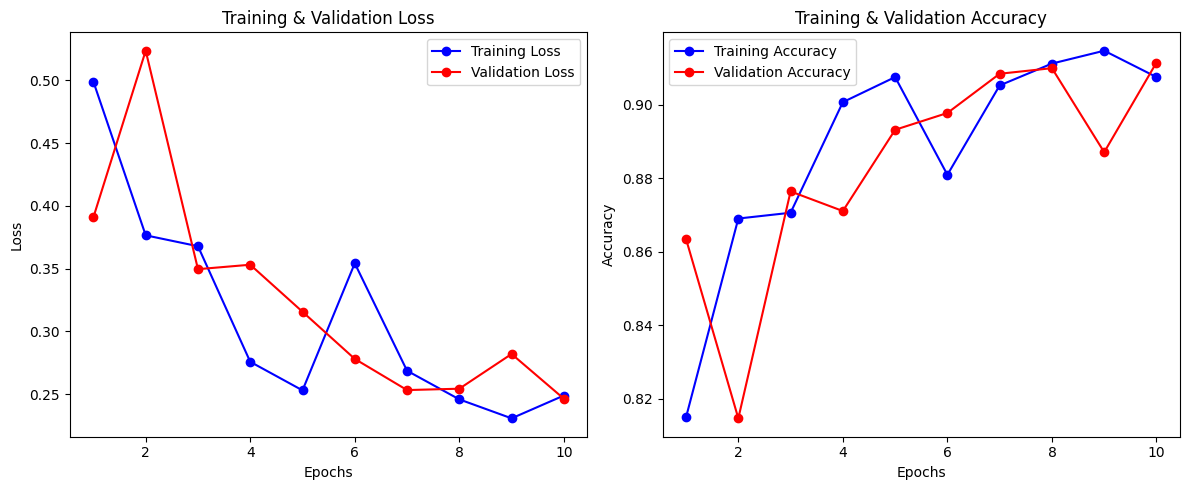

Best ResNet-50 model saved to: resnet50_best_model.pth


In [ ]:
# Best Model
#'lr': 0.01,
#'momentum': 0.9
#'weight_decay': 0.0001

import torch
import torch.nn as nn
import torchvision.models as models

# device
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

# best hyperparameters found
best_lr = 0.01
best_momentum = 0.9
best_weight_decay = 1e-4
num_classes = 4
num_epochs = 10

# build best ResNet-50 model
best_model = models.resnet50(pretrained=True)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    best_model.fc.parameters(),
    lr=best_lr,
    momentum=best_momentum,
    weight_decay=best_weight_decay
)

# move model to device
best_model = best_model.to(device)

# Use the same train() defined earlier that plots loss/accuracy
train(best_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

# save the trained model
model_path = "resnet50_best_model.pth"
torch.save(best_model.state_dict(), model_path)
print(f"Best ResNet-50 model saved to: {model_path}")


The best-performing model has been retrained and saved as resnet50_best_model.pth for future use. You can run this code to download the saved model and test it yourself.

The results from training the tuned ResNet-50 model show a steady decrease in loss and an accuracy that rises to around 90%, indicating effective learning and strong generalization.


# 5. Performance Evaluation

In [ ]:
# Evaluation function and confusion matrix

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, test_loader, device):
    # Initialize dictionaries to store correct and total predictions
    correct_pred = {classname: 0 for classname in test_loader.dataset.classes}
    total_pred = {classname: 0 for classname in test_loader.dataset.classes}

    # Set the model to evaluation mode
    model.eval()

    # Track the ground truth labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and labels for metric calculations
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Update the correct and total predictions per class
            for label, prediction in zip(labels, preds):
                classname = test_loader.dataset.classes[label]
                if label == prediction:
                    correct_pred[classname] += 1
                total_pred[classname] += 1

    # Calculate accuracy per class
    accuracy_per_class = {
        classname: correct_pred[classname] / total_pred[classname]
        if total_pred[classname] > 0 else 0
        for classname in test_loader.dataset.classes
    }

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)

    # Print the evaluation results
    print("\nAccuracy per class:")
    for classname, accuracy in accuracy_per_class.items():
        print(f"{classname}: {accuracy:.4f}")

    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    return overall_accuracy, accuracy_per_class, cm


'\nevaluate_model(model, test_loader, device)\n'

### a) Performance on Tuned ResNet-50 (best model)

#### i) Test Accuracy

In [ ]:
# Performance Evaluation on ResNet-50
# Load the Saved Model and Evaluate on Test Data (Roboflow)

print("\n--- Evaluating Tuned ResNet-50 (best model) on Test Data ---")

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader


# Device
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

# Load ResNet-50 with correct output size
num_classes = 4
model = models.resnet50(pretrained=False)   # pretrained=False when loading weights
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the saved weights
model.load_state_dict(torch.load("resnet50_best_model.pth", map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully!")


# Evaluate on Test Dataset
criterion = nn.CrossEntropyLoss()

test_loss = 0.0
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:   # test loader here
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / total
test_accuracy = correct.double() / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!
Test Loss: 0.1429
Test Accuracy: 0.9510


The final evaluation of the tuned ResNet-50 model on the test dataset demonstrates strong classification performance across all four tumor categories. The model achieved a **test accuracy** of **95.10%** and a low **test loss** of **0.1429**, indicating excellent generalization to unseen MRI images.

#### ii) Confusion Matrix

Class order: ['glioma', 'meningioma', 'notumor', 'pituitary']


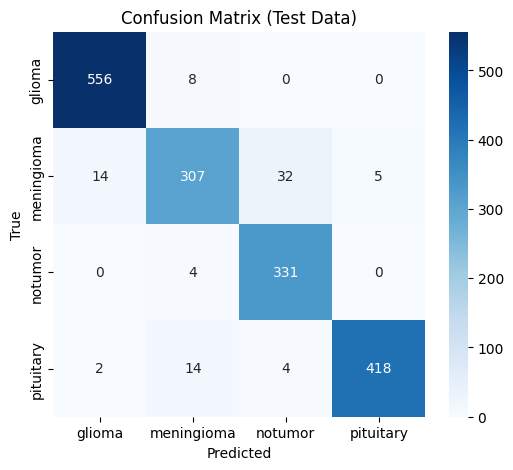

In [ ]:
# After: test_data = datasets.ImageFolder(test_dir, transform=data_transform)

classes = test_data.classes
print("Class order:", classes)

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random

model.eval()

all_imgs = []
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_imgs.extend(inputs.cpu())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=classes,  # from test_data.classes
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Data)")
plt.show()



The confusion matrix shows that the model correctly classified the majority of samples across all four tumor classes, demonstrating strong overall performance. It achieved especially high accuracy for glioma tumors (556 correct predictions) and pituitary (418 correct predictions). Misclassifications are relatively limited and occur primarily between notumor and the tumor categories which can be explained by early-stage or small tumors that are difficult to distinguish even for experts. As well as between meningioma and other tumor types which is expected given the overlapping visual characteristics seen in MRI scans. Importantly, the model shows very few errors between glioma and pituitary, indicating strong discriminative ability for these classes. Overall, the results confirm that the tuned ResNet-50 model generalizes well to unseen data and provides a reliable method for automated brain tumor classification.


#### iii) Visualization of Samples

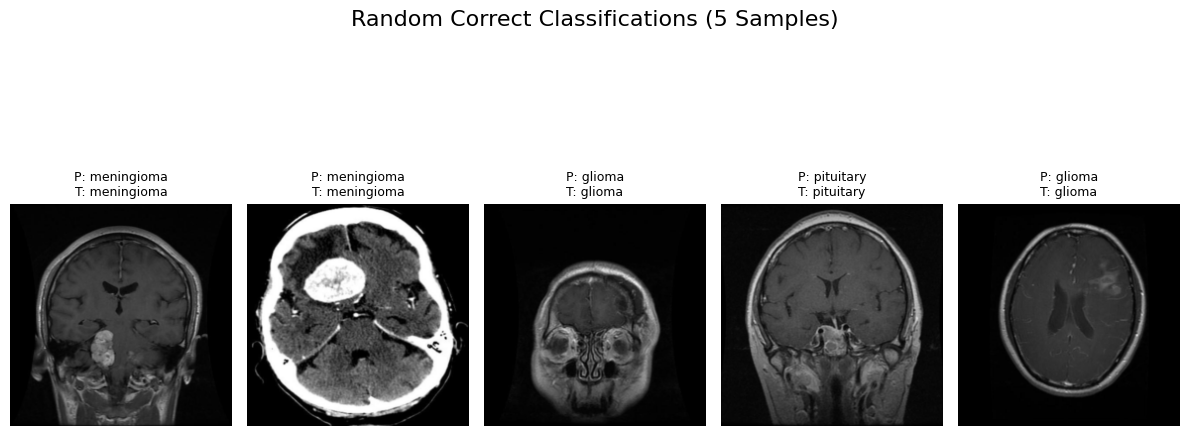

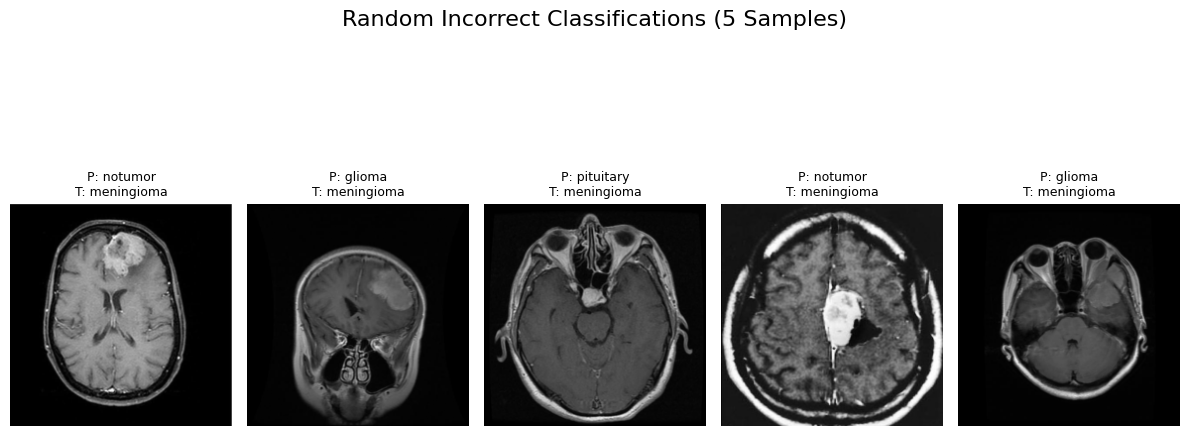

In [ ]:
# Visualization of Correct and Incorrect Samples

# Indices of correct / incorrect predictions
correct_idx = [i for i in range(len(all_labels)) if all_preds[i] == all_labels[i]]
incorrect_idx = [i for i in range(len(all_labels)) if all_preds[i] != all_labels[i]]

# Sample up to 5 from each (in case there are fewer)
correct_examples = random.sample(correct_idx, min(5, len(correct_idx)))
incorrect_examples = random.sample(incorrect_idx, min(5, len(incorrect_idx)))

def plot_examples(indices, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    for j, idx in enumerate(indices):
        img = all_imgs[idx]
        pred = all_preds[idx]
        true = all_labels[idx]

        plt.subplot(1, 5, j + 1)
        img_np = img.permute(1, 2, 0).numpy()
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"P: {classes[pred]}\nT: {classes[true]}", fontsize=9)

    plt.tight_layout()
    plt.show()

plot_examples(correct_examples, "Random Correct Classifications (5 Samples)")
plot_examples(incorrect_examples, "Random Incorrect Classifications (5 Samples)")


To further analyze model performance, a visualization step was added to display examples of both correct and incorrect classifications from the test dataset. Instead of selecting the first available samples, which often belong to the same class, the code collects all predictions and randomly selects five correctly classified images and five misclassified ones. This approach provides a more balanced and representative view of the model’s behavior across different tumor types. Presenting these examples helps illustrate how well the model distinguishes between classes and highlights specific cases where misclassifications occur, offering valuable insight into potential sources of error and areas for further improvement.

### b) Performance on Baseline Model

#### i) Test Accuracy and Confusion Matrix


--- Evaluating Baseline Model on Test Data ---

Accuracy per class:
glioma: 0.7766
meningioma: 0.7961
notumor: 0.9493
pituitary: 0.9840

Overall Accuracy: 0.8684


<Figure size 800x600 with 0 Axes>

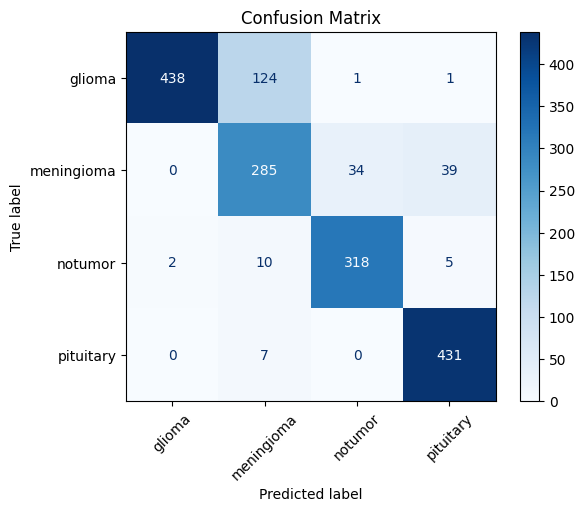

(0.8684365781710914,
 {'glioma': 0.776595744680851,
  'meningioma': 0.7960893854748603,
  'notumor': 0.9492537313432836,
  'pituitary': 0.9840182648401826},
 array([[438, 124,   1,   1],
        [  0, 285,  34,  39],
        [  2,  10, 318,   5],
        [  0,   7,   0, 431]]))

In [ ]:
# Performance Evaluation on Baseline Model

print("\n--- Evaluating Baseline Model on Test Data ---")

# Ensure model2 (BaselineCNN) is on the correct device and in evaluation mode
model2.eval()

# It calculates and prints accuracy, loss, and confusion matrix.
# Make sure 'device' and 'test_loader' are available from previous cells.
evaluate_model(model2, test_loader, device)

The baseline model achieved **86.84%** test accuracy, but as seen in the confusion matrix, it shows more misclassifications and weaker performance, highlighting the limits of a simple architecture for this complex task.


# 6. Performance Comparison

### a) ResNet-50 vs Baseline Model

**Overall Performance:**
ResNet-50 clearly outperforms the baseline CNN, achieving 95.10% accuracy compared to 86.84%. This gap reflects the strength of deep, pretrained architectures over simple models built from scratch.

**Feature Extraction Ability:**
ResNet-50 benefits from 50 layers and pretrained ImageNet weights, enabling it to capture subtle textures, shapes, and patterns in MRI scans.
The baseline CNN, with only three convolutional layers, has limited capacity to learn complex tumor features.

**Generalization:**
As shown in the confusion matrices, ResNet-50 makes fewer misclassifications across all tumor types, especially in challenging cases where tumors have similar visual characteristics.
The baseline model shows more confusion between glioma, meningioma, and notumor, indicating weaker generalization.

**Architecture Depth & Transfer Learning:**
ResNet-50 leverages residual connections and deep feature hierarchies, enabling much stronger learning.
The baseline CNN must learn all features from scratch, making it more prone to underfitting and less robust.

**Practical Impact:**
The high performance of ResNet-50 makes it more suitable for real-world medical image analysis, whereas the baseline CNN serves primarily as a benchmark to illustrate how much accuracy is gained from using an advanced architecture.

--------------------------------------------------------------
### b) ResNet-50 vs Related Works
The dataset we used to train our model is widely adopted, which means many highly optimized models have already been developed using the same images. For comparison, we examined two well-known Kaggle models that achieve accuracies around 99%. Their superior performance can be attributed to several factors: they use more advanced architectures like Xception and fully fine-tuned ResNet variants, they rely on larger input image resolutions that preserve more visual detail, and they are trained for significantly more epochs, allowing the networks to learn increasingly refined representations. In addition, these models often unfreeze deeper layers and perform more aggressive fine-tuning, which can further boost accuracy. These differences help explain why their performance exceeds ours and highlight areas where we can continue improving our model.


**Xception Model (99.24%) from Kaggle**
https://www.kaggle.com/code/yousefmohamed20/brain-tumor-mri-accuracy-99#2.3-Data-preprocessing


* More advanced architecture
* Higher input resolution


**ResNet18 (99.69%) from Kaggle**  
https://www.kaggle.com/code/abdocan/brain-tumor-classification-pytorch-99-7-test#Model-2-(ResNet18)

* More layers were fine-tuned
* More training time (60 epochs)



# 7. Discussion

Through our experience doing this project, our group learned a few important takeaways. The first being the importance and convenience of utilizing transfer learning. When we implemented the ResNet-50 model, we experienced faster training and better feature extraction from our dataset. The pre-trained ResNet-50 model, as any other model used for transfer learning requires less data to train than if we created a model from scratch. This was extremely critical because medical data is difficult to get in large amounts in the first place. We also learned about the importance of dissecting our results class by class, rather than just by the overall accuracy score through metrics like the confusion matrix. This helped capture weaknesses in our model that we would not have been able to detect from one overall accuracy score alone. Finally, we also learned that it is very important and useful to use different datasets for training / validation and testing. Normally in our class assignments, we split one dataset into train/val/test, but in this assignment, we used a completely different dataset for train/val and test. We thought initially that this would be best for deployment (test), but we actually ended up getting a higher test accuracy than in the train/val phase, which led us to question whether the test data was an easier set, or if the examples were of better definition or overall more clear. If we had more time to work on this project, we would have combed through each dataset more to explore why this may have occurred.

Through the training and evaluation of our models, we also learned about a few limitations with our topic that are important if we ever wanted to continue fine tuning this project in the future. One limitation that came up involved the misclassification of low contrast samples and smaller tumor samples. There could have been mislabeled samples, something we could have look into more if time permitted. Another quai-limitation included the idea of data augmentation. From our understanding, neither datasets were augmented, which (for the training data at least), would have helped make the training more robust and adaptive, but we also realized that augmentation would have been tricky because it could have excessively distorted tumor features to the point where a sample would look more like another tumor class and lead to misclassification as well.

Finally, we wanted to discuss some of the ethics and fairness principles that our group considers while reflecting on our work. First, transparency with pre-trained models. Pre-trained models can improve results, but can also hide how they internally go through the feature learning process, leading to another issue of interpretability. In the medical field, the reasoning a clinician makes a decision should be sound and reasonable, with little to no doubt in their choice. Using AI in the decision making process, especially using AI based on pre-trained models, such as the ResNet-50 model we used in this assignment, makes it harder for clinicians to have full confidence in their judgement. It also makes it harder for clinicians to be able to fully justify their decisions. This begs the question of whether professions that utiize AI as a tool should come with the expectation of understanding it? We think this will be an important topic of debate as AI systems become more deployable in the future.

# Reproducibilty

It is possible to reproduce our results. The datasets can be downloaded from the provided links and used after applying the same naming conventions. By running the supplied code, similar model performance can be achieved. However, it is important to note that training the models may take a considerable amount of time.

# Demo

How to use this cell:

1. Upload the best model file: resnet50_best_model.pth

2. Upload an image to test: demo_image.jpg

3. Run this cell only — no other cells are required.

The output will display the uploaded image along with the model’s predicted class.

You can watch our demo video: https://drive.google.com/file/d/1HPsSqxOowycgL-8DYcT4narRqJvrNbwK/view?usp=drive_link

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models

Image path set to: /content/demo_image.jpg
Class order: ['glioma', 'meningioma', 'notumor', 'pituitary']

--- Predicting for Single Demo Image ---
Model loaded successfully from resnet50_best_model.pth!


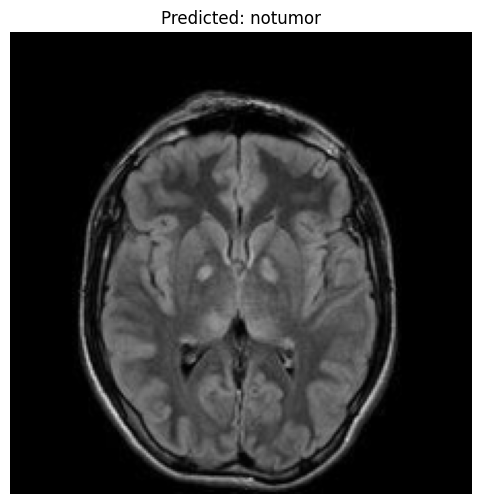

Predicted class for demo_image.jpg: notumor


In [ ]:
# Define the path to your single demo image
single_image_path = '/content/demo_image.jpg'

# --- IMPORTANT ---
# Please upload your single image file to the '/content/' directory
# in Colab and ensure it is named 'demo_image.jpg',
# or update the 'single_image_path' variable above.
# -------------------

# Define data transformations (same as for test data)
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Define the class names, based on the dataset used for training
# (glioma, meningioma, notumor, pituitary)
# This order is derived from the datasets.ImageFolder output during training
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Check if the image file exists
if not os.path.exists(single_image_path):
    print(f"Warning: The image file '{single_image_path}' does not exist.")
    print("Please upload your image and ensure the path is correct.")
else:
    print(f"Image path set to: {single_image_path}")
    print(f"Class order: {classes}")

####

if os.path.exists(single_image_path):
    print("\n--- Predicting for Single Demo Image ---")

    # Define device
    device = torch.device("mps" if torch.backends.mps.is_available()
                          else "cuda" if torch.cuda.is_available()
                          else "cpu")

    # Load ResNet-50 with correct output size
    num_classes = 4
    best_model = models.resnet50(pretrained=False)   # pretrained=False when loading weights
    best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)

    # Load the saved weights from the .pth file
    model_path = "resnet50_best_model.pth"
    try:
        best_model.load_state_dict(torch.load(model_path, map_location=device))
        best_model = best_model.to(device)
        best_model.eval() # Set the model to evaluation mode
        print(f"Model loaded successfully from {model_path}!")
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found. Please ensure it's uploaded to /content/.")
        best_model = None # Set to None to prevent further errors
    except Exception as e:
        print(f"Error loading model: {e}")
        best_model = None

    if best_model is not None:
        try:
            # Load image
            image = Image.open(single_image_path).convert('RGB')

            # Apply transformations
            input_tensor = data_transform(image)

            # Add batch dimension and move to device
            input_batch = input_tensor.unsqueeze(0).to(device)

            # Get prediction
            with torch.no_grad():
                outputs = best_model(input_batch)
                _, preds = torch.max(outputs, 1)
                predicted_class_idx = preds.item()
                predicted_class_name = classes[predicted_class_idx]

            # Display the image
            plt.figure(figsize=(6, 6))
            plt.imshow(np.transpose(input_tensor.cpu().numpy(), (1, 2, 0)))
            plt.title(f"Predicted: {predicted_class_name}")
            plt.axis('off')
            plt.show()

            print(f"Predicted class for {os.path.basename(single_image_path)}: {predicted_class_name}")

        except Exception as e:
            print(f"Error processing image: {e}")
            print("Please ensure the image file is valid.")
    else:
        print("Model could not be loaded, skipping prediction.")
else:
    print("Cannot perform prediction: Single demo image file not found.")



# Presentation

You can check out our presentation slides from links:

Presentation slides: https://docs.google.com/presentation/d/1X8mEp-zcDX9uqlxSmMJEoQHrBfulegTp2vzj-z-gYjs/edit?slide=id.g3aabbcaba8f_0_27#slide=id.g3aabbcaba8f_0_27

# Resources

https://ca.indeed.com/career-advice/finding-a-job/how-to-become-a-radiologist?

https://www.uottawa.ca/faculty-medicine/radiology/residency

https://link.springer.com/article/10.1186/s13244-021-01031-4

https://www.kaggle.com/code/yousefmohamed20/brain-tumor-mri-accuracy-99#2.3-Data-preprocessing
